# Online-NST, Алгоритм Гатиса

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torchvision.models import vgg19

from PIL import Image

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_device(device)
device

device(type='cuda')

## 1. Свёрточная нейросеть для извлечения признаков

Возьмём первые 11 слоев предобученной VGG19, среди которых 5 свёрток, и заморозим их, так как оптимизировать их параметры мы не собираемся.

In [36]:
base_cnn = vgg19(pretrained=True).features[0 : 11].to(device)

for param in base_cnn.parameters():
    param.requires_grad = False

base_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## 2. Слои лоссов

Для рассчёта функции потерь добавим слои для потери контента и потери стиля.

In [37]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach().to(device)
        
    def forward(self, inp):
        self.loss = F.mse_loss(inp, self.target).to(device)
        return inp
    

class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = StyleLoss.gram_matrix(target).detach().to(device)
        
    @staticmethod
    def gram_matrix(inp):
        batch_size, nmaps, w, h = inp.size()
    
        features = inp.view(batch_size * nmaps, w * h) # Получаем для каждой карты признаков вектор размера wxh
    
        G = torch.mm(features, features.T)
    
        return G.div(batch_size * nmaps * w * h)

    
    def forward(self, inp):
        G = StyleLoss.gram_matrix(inp).to(device)
        self.loss = F.mse_loss(G, self.target).to(device)
        return inp

## 3. Слой нормализации

In [38]:
# VGG обучалась на картинках с определенными средним значением и средним стандратным отклонением.
# Поэтому нужно приводить свои изображение к примерно такому же распределению.

VGG19_NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406])
VGG19_NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean=VGG19_NORMALIZATION_MEAN,
                 std=VGG19_NORMALIZATION_STD):
       super(Normalization, self).__init__()
       self.mean = torch.tensor(mean).view(-1, 1, 1)
       self.std = torch.tensor(std).view(-1, 1, 1)
   
    def forward(self, img):
       return (img - self.mean) / self.std

## 4. Функция-конструктор модели переноса стиля

In [39]:
CONTENT_LAYERS_DEFAULT = ['Conv_4']
STYLE_LAYERS_DEFAULT = ['Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Conv_5']

In [40]:
class StyleModel:
    """
    Класс для создания интерфейса по переносу стиля
    """
    def __init__(self, base_cnn, content_img, style_img, normalization_mean, normalization_std, content_layers, style_layers):
        content_img = content_img.to(device)
        style_img = style_img.to(device)
        self.model = nn.Sequential().to(device)
        self.content_losses = []
        self.style_losses = []
        
        self.model.add_module("ImageNorm", Normalization(mean=normalization_mean, std=normalization_std).to(device))

        conv_counter: int = 0
        module_name: str = ""
        
        for layer in base_cnn.children():
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
                module_name = f"Conv_{conv_counter}"
                
            elif isinstance(layer, nn.ReLU):
                module_name = f"ReLU_{conv_counter}"
                layer = nn.ReLU(inplace=False)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_name = f"MaxPool2d_{conv_counter}"
            
            else:
                raise ValueError
            
            self.model.add_module(module_name, layer.to(device))

            if module_name in content_layers:
                target = self.model(content_img).detach().to(device)
                content_loss_module = ContentLoss(target)
                self.content_losses.append(content_loss_module)
                self.model.add_module(f"ContentLoss_{conv_counter}", content_loss_module)
                
            if module_name in style_layers:
                target = self.model(style_img).detach().to(device)
                style_loss_module = StyleLoss(target)
                self.style_losses.append(style_loss_module)
                self.model.add_module(f"StyleLoss_{conv_counter}", style_loss_module)
                
        self.model.to(device)

    
    def __repr__(self):
        return f'{self.__class__.__name__}(model = {self.model})'


    def transfer_style(self, input_image, num_steps=300, style_weight=10000, content_weight=1, print_logs=False):
        input_image = input_image.to(device)
        
        input_image.requires_grad = True
        self.model.eval()
        
        optimizer = optim.Adam([input_image], lr=0.05)

        for i in range(num_steps):
            optimizer.zero_grad()

            self.model(input_image)
            content_final_loss = 0.0
            style_final_loss = 0.0
            
            for content_loss in self.content_losses:
                content_final_loss += content_loss.loss

            for style_loss in self.style_losses:
                style_final_loss += style_loss.loss

            loss = content_weight * content_final_loss + style_weight * style_final_loss
            loss.backward()
            
            optimizer.step()
            
            with torch.no_grad():
                input_image.clamp_(0, 1)

            if print_logs:
                if i % 10 == 0:
                    print(f"Эпоха номер {i + 1}")
                    print(f"content_epoch_loss: {content_final_loss}")
                    print(f"style_epoch_loss: {style_final_loss}")
                    print(f"final_epoch_loss: {loss}")
                    plt.imshow(ToPILImage()(input_image[0]))
                    plt.show()
                
        with torch.no_grad():
            input_image.clamp_(0, 1)
            
        return input_image

## Тестирование

In [41]:
IMSIZE = 512

loader = Compose([
    Resize(size=IMSIZE),
    ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image


style_images_path = "/kaggle/input/images2-0/data/styles/"
content_images_path = "/kaggle/input/images2-0/data/contents/"

style_file_names = ["picasso.jpg", "mun.jpg", "style.jpg", "vangog.jpg", "winter.jpg"]
content_file_names = ["content.jpeg", "dancing.jpg", "me.jpg", "summer.jpg"]

style_images = [image_loader(style_images_path + image_name) for image_name in style_file_names]
content_images = [image_loader(content_images_path + image_name) for image_name in content_file_names]

In [42]:
import matplotlib.pyplot as plt

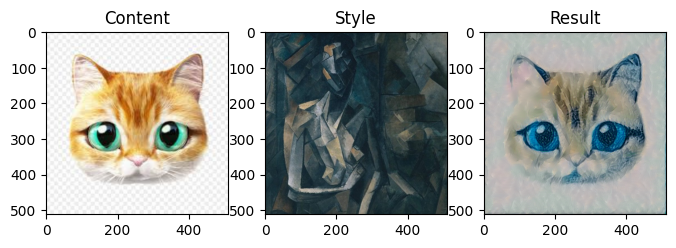

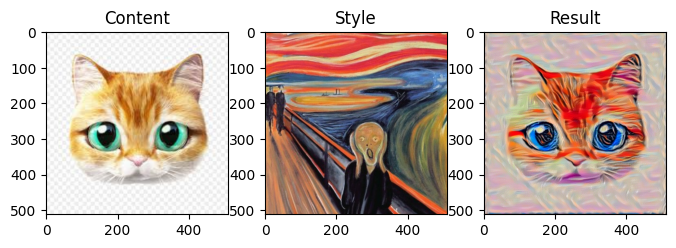

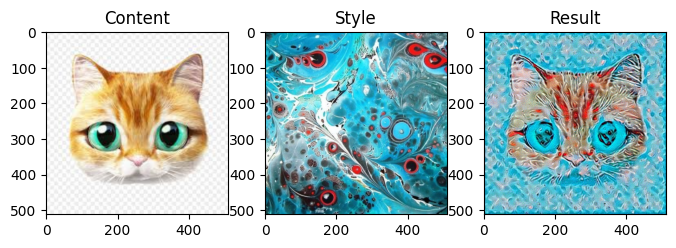

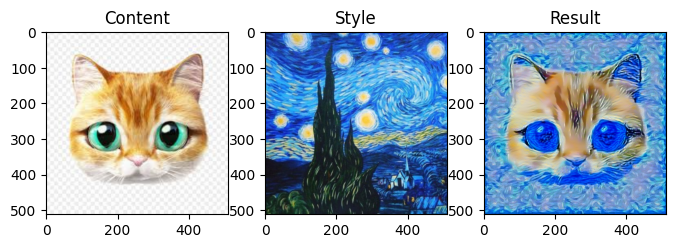

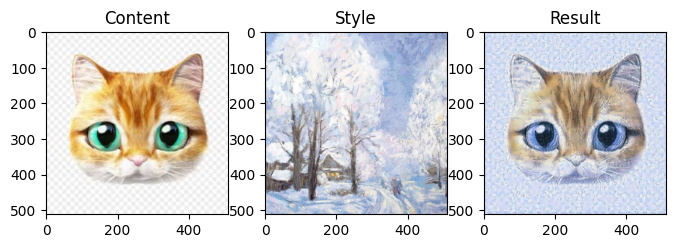

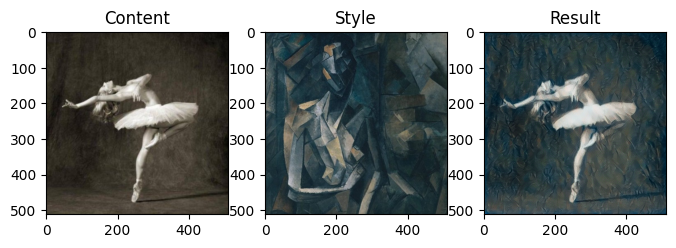

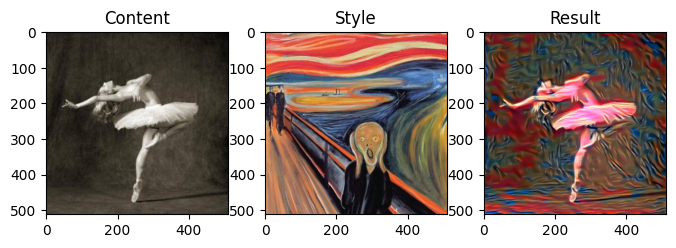

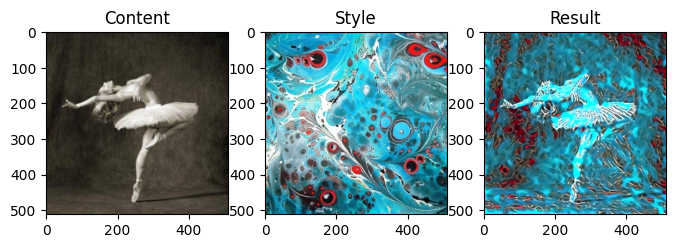

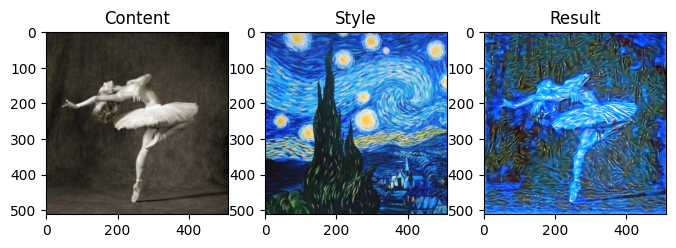

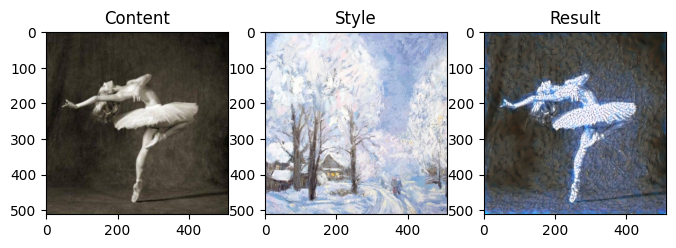

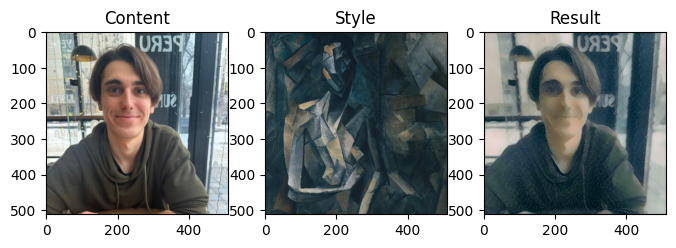

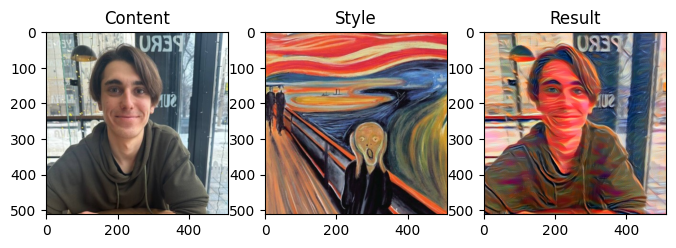

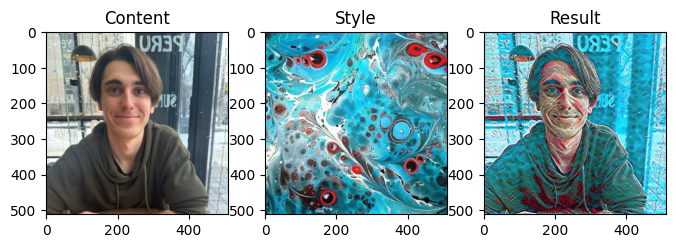

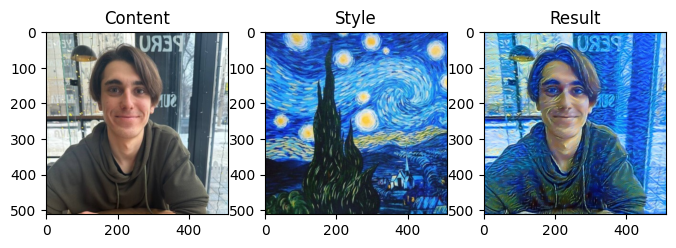

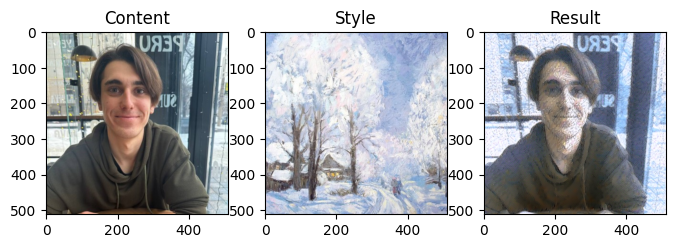

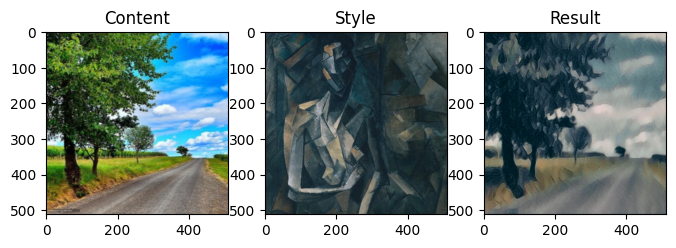

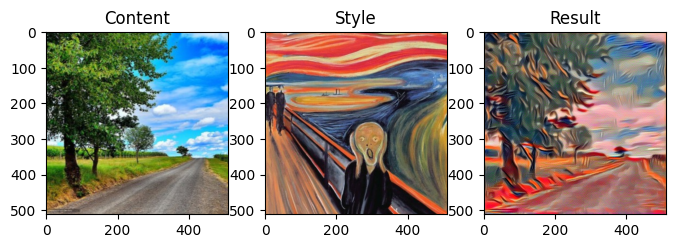

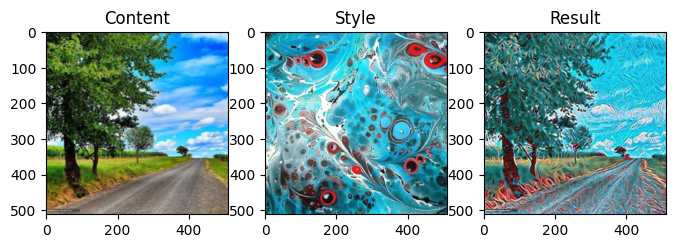

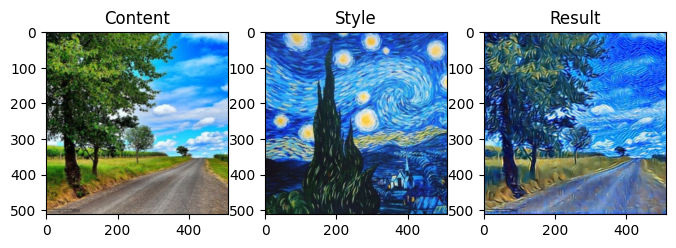

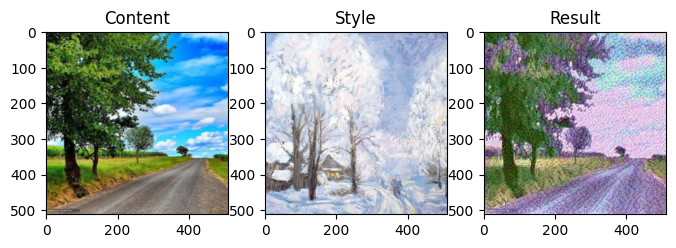

In [43]:
for content_img in content_images:
    for style_img in style_images:
        input_img = content_img.clone()
        
        style_model = StyleModel(
            base_cnn=base_cnn,
            content_img=content_img,
            style_img=style_img,
            normalization_mean=VGG19_NORMALIZATION_MEAN,
            normalization_std=VGG19_NORMALIZATION_STD,
            content_layers=CONTENT_LAYERS_DEFAULT,
            style_layers=STYLE_LAYERS_DEFAULT
        )

        output = style_model.transfer_style(input_image=input_img, num_steps=500, style_weight=10**10, print_logs=False)
        
        fig, axes = plt.subplots(1, 3, figsize=(8, 13))
        axes[0].set_title("Content")
        axes[1].set_title("Style")
        axes[2].set_title("Result")
        axes[0].imshow(ToPILImage()(content_img[0]))
        axes[1].imshow(ToPILImage()(style_img[0]))
        axes[2].imshow(ToPILImage()(output[0]))
        plt.show()
